In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1899: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}

In [3]:
db_schema = None
db = Database(credentials=credentials)

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [4]:
dataset = pd.read_csv('./Weather.csv', dtype={"Snowfall":object, "PoorWeather":object, "SNF": object, "TSHDSBRSGF":object})

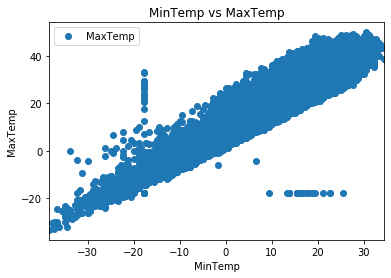

         Date    MinTemp    MaxTemp
0    1942-7-1  22.222222  25.555556
1    1942-7-2  21.666667  28.888889
2    1942-7-3  22.222222  26.111111
3    1942-7-4  22.222222  26.666667
4    1942-7-5  21.666667  26.666667
5    1942-7-6  21.666667  26.666667
6    1942-7-7  22.777778  28.333333
7    1942-7-8  22.222222  26.666667
8    1942-7-9  22.777778  27.222222
9   1942-7-10  21.666667  25.555556
10  1942-7-11  21.666667  25.555556
11  1942-7-12  22.222222  24.444444
12  1942-7-13  21.666667  26.111111
13  1942-7-14  22.222222  26.111111
14  1942-7-15  22.777778  25.555556
15  1942-7-16  21.111111  26.111111
16  1942-7-17  22.222222  28.333333
17  1942-7-18  21.111111  26.666667
18  1942-7-19  21.666667  27.777778
19  1942-7-20  20.000000  26.111111


In [5]:
df = dataset[['Date','MinTemp','MaxTemp']]
df.plot(x='MinTemp', y='MaxTemp', style='o')
plt.title('MinTemp vs MaxTemp')
plt.xlabel('MinTemp')
plt.ylabel('MaxTemp')
plt.show()
print (df.head(20))

In [9]:
print (df['Date'].count())
result = pd.DataFrame()
#result['MinTemp'] = df['MinTemp']
#result['MaxTemp'] = df['MaxTemp']

class GenValue(base.BaseTransformer):
    count = -1
    def __init__ (self, input_items, output_items):
        super().__init__()
        self.dataset = dataset # full dataframe as fixed input
        self.input_items  = input_items # columns
        self.output_items = output_items
        self._output_list = output_items
        if len(output_items) == 0:
            self._output_list = ['MaxTemp']
        self.count += 1
        self.cnt = self.count
        print (self.cnt)
        
    def execute(self, df):
        dff = df.copy()
        if (len(self.output_items) > 0 and len(self.output_items) == len(self.input_items)):
            print (self.output_items)
            dff[self.output_items] = self.dataset[self.input_items]
            print (dff.head(3))
        elif self.input_items[0] in df.columns:
            print ("Copy predictor: ",self.cnt, "  input item ", self.input_items[0])
            result['MinTemp'] = pd.Series(df['MinTemp'].to_numpy())
            result['MaxTemp'] = pd.Series(df['MaxTemp'].to_numpy())
            arr = df[self.input_items[0]].to_numpy()
            result['MaxPred' + str(self.cnt)] = pd.Series(arr)
            self.cnt += 1
        else:
            print ('Input item 0: ', self.input_items[0])
        return dff
    
    @classmethod
    def build_ui(cls):
        # define arguments that behave as function inputs
        inputs = []
        inputs.append(UIMultiItem(name='input_items',
                                  datatype=float,
                                  description="Columns to get data from",
                                  is_output_datatype_derived = True)
                            
                      )
        outputs = []
        return (inputs, outputs)

    
dff = pd.DataFrame()
gv = GenValue(['MinTemp','MaxTemp'], ['MinTemp','MaxTemp'])
dff = gv.execute(dff)
gv = GenValue(['MinTemp'],[])
dff2 = gv.execute(dff)
print (dff.head(10))
print (dff2.head(10))


job_settings = {
    'delete_existing_models' : True
}

et = metadata.EntityType('weather', db,
                          Column('MinTemp',Float()), Column('MaxTemp',Float()), Column('MaxPred',Float()),
                          bif.EntityDataGenerator(output_item='generator_ok'),
                          #bif.EntityDataGenerator(output_item='MaxTemp'),
                          GenValue(['MinTemp','MaxTemp'],['MinTemp','MaxTemp']),
                          #GenValue(input_item='MaxTemp'),
                          estimator.SimpleRegressor(features = ['MinTemp'], targets = ['MaxTemp'], predictions = ['MaxPred']),
                          GenValue(['MaxPred'],[]),
                          **{'_timestamp' : 'evt_timestamp','_db_schema' : db_schema})

et.register(raise_error=True)
start_date = dt.datetime.utcnow() - dt.timedelta(days=30)
et.exec_local_pipeline(start_ts = start_date, **job_settings)

119040
0
['MinTemp', 'MaxTemp']
     MinTemp    MaxTemp
0  22.222222  25.555556
1  21.666667  28.888889
2  22.222222  26.111111
0
Copy predictor:  0   input item  MinTemp
     MinTemp    MaxTemp
0  22.222222  25.555556
1  21.666667  28.888889
2  22.222222  26.111111
3  22.222222  26.666667
4  21.666667  26.666667
5  21.666667  26.666667
6  22.777778  28.333333
7  22.222222  26.666667
8  22.777778  27.222222
9  21.666667  25.555556
     MinTemp    MaxTemp
0  22.222222  25.555556
1  21.666667  28.888889
2  22.222222  26.111111
3  22.222222  26.666667
4  21.666667  26.666667
5  21.666667  26.666667
6  22.777778  28.333333
7  22.222222  26.666667
8  22.777778  27.222222
9  21.666667  25.555556
0
0


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


TBD ***** - Add stages for usage stats and write to MessageHub
['MinTemp', 'MaxTemp']
                                 deviceid devicetype logicalinterface_id  \
id    evt_timestamp                                                        
73002 2019-08-12 06:52:02.864814    73002    weather                       
73003 2019-08-12 06:57:02.864814    73003    weather                       
73000 2019-08-12 07:02:02.864814    73000    weather                       

                                 eventtype format updated_utc  MaxTemp  \
id    evt_timestamp                                                      
73002 2019-08-12 06:52:02.864814        tp               None      NaN   
73003 2019-08-12 06:57:02.864814        ey               None      NaN   
73000 2019-08-12 07:02:02.864814        te               None      NaN   

                                  MinTemp                 _timestamp  \
id    evt_timestamp                                                    
73002 2019-08-12 0

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWar

Copy predictor:  0   input item  MaxPred
['MinTemp', 'MaxTemp']
                                 deviceid devicetype logicalinterface_id  \
id    evt_timestamp                                                        
73004 2019-08-19 06:52:02.864814    73004    weather                       
73000 2019-08-19 06:57:02.864814    73000    weather                       
73003 2019-08-19 07:02:02.864814    73003    weather                       

                                 eventtype format updated_utc  MaxTemp  \
id    evt_timestamp                                                      
73004 2019-08-19 06:52:02.864814        yp               None      NaN   
73000 2019-08-19 06:57:02.864814        tt               None      NaN   
73003 2019-08-19 07:02:02.864814        te               None      NaN   

                                  MinTemp                 _timestamp  \
id    evt_timestamp                                                    
73004 2019-08-19 06:52:02.864814      Na

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWar

Copy predictor:  1   input item  MaxPred
['MinTemp', 'MaxTemp']
                                 deviceid devicetype logicalinterface_id  \
id    evt_timestamp                                                        
73002 2019-08-30 23:29:35.075687    73002    weather                       
73003 2019-08-30 23:34:35.075687    73003    weather                       
73000 2019-08-30 23:39:35.075687    73000    weather                       

                                 eventtype format updated_utc  MaxTemp  \
id    evt_timestamp                                                      
73002 2019-08-30 23:29:35.075687        pv               None      NaN   
73003 2019-08-30 23:34:35.075687        en               None      NaN   
73000 2019-08-30 23:39:35.075687        ep               None      NaN   

                                  MinTemp                 _timestamp  \
id    evt_timestamp                                                    
73002 2019-08-30 23:29:35.075687      Na

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWar

Copy predictor:  2   input item  MaxPred
['MinTemp', 'MaxTemp']
                                 deviceid devicetype logicalinterface_id  \
id    evt_timestamp                                                        
73001 2019-09-02 06:54:35.075687    73001    weather                       
73004 2019-09-02 06:59:35.075687    73004    weather                       
73001 2019-09-02 07:04:35.075687    73001    weather                       

                                 eventtype format updated_utc  MaxTemp  \
id    evt_timestamp                                                      
73001 2019-09-02 06:54:35.075687        ev               None      NaN   
73004 2019-09-02 06:59:35.075687        te               None      NaN   
73001 2019-09-02 07:04:35.075687        pt               None      NaN   

                                  MinTemp                 _timestamp  \
id    evt_timestamp                                                    
73001 2019-09-02 06:54:35.075687      Na

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWar

Copy predictor:  3   input item  MaxPred
['MinTemp', 'MaxTemp']
                                 deviceid devicetype logicalinterface_id  \
id    evt_timestamp                                                        
73001 2019-09-09 06:52:39.611895    73001    weather                       
73000 2019-09-09 06:57:39.611895    73000    weather                       
      2019-09-09 07:02:39.611895    73000    weather                       

                                 eventtype format updated_utc  MaxTemp  \
id    evt_timestamp                                                      
73001 2019-09-09 06:52:39.611895        en               None      NaN   
73000 2019-09-09 06:57:39.611895        ve               None      NaN   
      2019-09-09 07:02:39.611895        te               None      NaN   

                                  MinTemp                 _timestamp  \
id    evt_timestamp                                                    
73001 2019-09-09 06:52:39.611895      Na

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWar

Copy predictor:  4   input item  MaxPred


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [14]:
result2 = result.dropna()
result2.describe()

,MinTemp,MaxTemp,MaxPred0,MaxPred1,MaxPred2,MaxPred3,MaxPred4
count,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000,14748.000000
mean,0.204569,0.192571,0.160900,0.199116,0.195737,0.098890,0.192324
std,1.004231,1.004320,0.013022,0.009784,0.011531,0.030549,0.017704
min,-3.686805,-3.461910,0.067164,0.161252,0.157928,-0.795974,-0.191109
25%,-0.471296,-0.493503,0.146407,0.192477,0.186420,0.093922,0.178595
50%,0.200880,0.188654,0.164876,0.199079,0.191120,0.096701,0.196675
75%,0.895506,0.864613,0.167969,0.205672,0.204703,0.106150,0.205914
max,4.209298,4.004946,0.283059,0.242438,0.291840,1.035922,0.731684
